## From Model

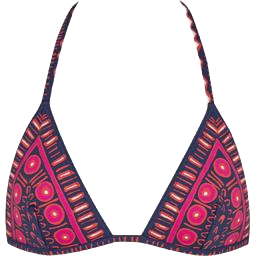

In [2]:
from skimage import io
from transformers import AutoModelForImageSegmentation
from torchvision.transforms.functional import normalize
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

def preprocess_image(im: np.ndarray, model_input_size: list) -> torch.Tensor:
    if len(im.shape) < 3:
        im = im[:, :, np.newaxis]
    # orig_im_size=im.shape[0:2]
    im_tensor = torch.tensor(im, dtype=torch.float32).permute(2,0,1)
    im_tensor = F.interpolate(torch.unsqueeze(im_tensor,0), size=model_input_size, mode='bilinear')
    image = torch.divide(im_tensor,255.0)
    image = normalize(image,[0.5,0.5,0.5],[1.0,1.0,1.0])
    return image

def postprocess_image(result: torch.Tensor, im_size: list)-> np.ndarray:
    result = torch.squeeze(F.interpolate(result, size=im_size, mode='bilinear') ,0)
    ma = torch.max(result)
    mi = torch.min(result)
    result = (result-mi)/(ma-mi)
    im_array = (result*255).permute(1,2,0).cpu().data.numpy().astype(np.uint8)
    im_array = np.squeeze(im_array)
    return im_array

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4",trust_remote_code=True)
model.to(device)

# prepare input
image_path = "data/DAM/01BB01A2102X4847.jpeg"
orig_im = io.imread(image_path)
orig_im_size = orig_im.shape[0:2]
model_input_size = orig_im_size
image = preprocess_image(orig_im, model_input_size).to(device)

# inference 
result=model(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_mask_im = Image.fromarray(result_image)
orig_image = Image.open(image_path)
no_bg_image = orig_image.copy()
no_bg_image.putalpha(pil_mask_im)

display(no_bg_image)

## From pipeline

Device set to use cuda:0


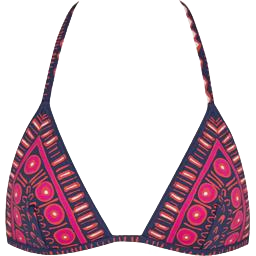

In [3]:
from transformers import pipeline
image_path = "data/DAM/01BB01A2102X4847.jpeg"
pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)
pillow_mask = pipe(image_path, return_mask = True) # outputs a pillow mask
pillow_image = pipe(image_path) # applies mask on input and returns a pillow image

display(pillow_image)

## Data Augmentation

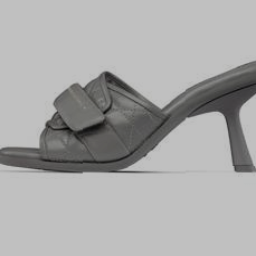

In [344]:
from torchvision import transforms
from torchvision.transforms import (
    RandomRotation, RandomResizedCrop, RandomHorizontalFlip, 
    ColorJitter, RandomGrayscale, GaussianBlur, RandomErasing
)
import cv2

# Définir les transformations
transform1 = RandomRotation(degrees=30,fill=256)  # Rotation jusqu'à 30 degrés
transform2 = RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))  # Taille et échelle variables
transform3 = RandomHorizontalFlip(p=0.5)  # Flip horizontal avec probabilité 50%
transform4 = ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
transform5 = RandomGrayscale(p=0.2)  # Convertir en noir et blanc avec probabilité 20%
transform6 = GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
transform7 = RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))

# Pipeline de data augmentation
data_augmentation = transforms.Compose([
    transforms.ToPILImage(),  # Convertir NumPy en PIL.Image
    transform1,
    transform3,
    transform4,
    transform2,
    transforms.ToTensor(),  # Reconvertir en tenseur
])

# Lire une image avec OpenCV et la convertir en RGB
image = cv2.imread("data/DAM/KDQ731CQCS33G.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Appliquer les augmentations
transformed = data_augmentation(image)

# Convertir le tenseur en image pour l'afficher
transformed_image = transforms.ToPILImage()(transformed)

display(transformed_image)

## Combined pipeline

Device set to use cuda:0


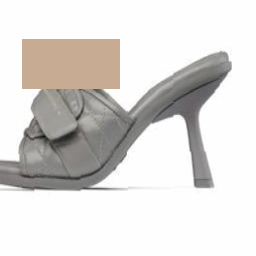

In [359]:
from transformers import pipeline
from torchvision import transforms
from torchvision.transforms import (
    RandomRotation, RandomResizedCrop, RandomHorizontalFlip, 
    ColorJitter, GaussianBlur, RandomErasing, RandomAffine, RandomPerspective
)

# Étape 1 : Chargement du pipeline de segmentation
segment_pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)

# Étape 2 : Définir les transformations de data augmentation

# Pipeline de data augmentation
data_augmentation_pipe = transforms.Compose([
    transforms.ToPILImage(),  # Convertir NumPy en PIL.Image
    RandomRotation(degrees=45,fill=256),
    RandomHorizontalFlip(p=0.5),
    RandomAffine(degrees=0, translate=(0.2, 0.2), fill=256),
    RandomPerspective(p=0.5,distortion_scale=0.4,fill=256),
    ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.01),
    RandomResizedCrop(size=(256, 256), scale=(0.75, 2.0)),
    transforms.ToTensor(),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)),
    RandomErasing(p=0.5, scale=(0.05, 0.25), ratio=(0.3, 3.3), value=(56,85,109)),
])

# Étape 3 : Pipeline combinée
def process_and_augment(image_path):
    # Charger l'image originale cropée
    pillow_image = segment_pipe(image_path)  # Appliquer le masque et obtenir une image PIL
    # pillow_mask = segment_pipe(image_path, return_mask=True)  # Obtenir le masque en format PIL

    image_np = cv2.cvtColor(np.array(pillow_image), cv2.COLOR_RGB2BGR)
    
    # Convertir en RGB pour appliquer les transformations PyTorch
    image_np_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    
    # Appliquer les transformations
    augmented_tensor = data_augmentation_pipe(image_np_rgb)
    
    # Convertir le tenseur transformé en une image PIL pour l'affichage
    augmented_image = transforms.ToPILImage()(augmented_tensor)
    
    return augmented_image

# Étape 4 : Tester la pipeline
image_path = "data/DAM/KDQ731CQCS33G.jpeg"
final_image = process_and_augment(image_path)

display(final_image)
